<a href="https://colab.research.google.com/github/subhashl1/Multi-Armed-Bandit/blob/main/MultiArmedBandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import gym
from tqdm import tqdm
import time

from gym import spaces
from gym.utils import seeding

class ArmedBandits(gym.Env):
    
    def __init__(self, mean, stddev):
        assert len(mean.shape) == 2
        assert len(stddev.shape) == 2
        
        super(ArmedBandits, self).__init__()
        # Define action and observation space
        self.num_bandits = mean.shape[1]
        self.num_experiments = mean.shape[0]
        self.action_space = spaces.Discrete(self.num_bandits)
        
        # Theres one state only in the k-armed bandits problem
        self.observation_space = spaces.Discrete(1)
        self.mean = mean
        self.stddev = stddev
        
    def step(self, action):
        # Sample from the specified bandit using it's reward distribution
        assert (action < self.num_bandits).all()
        
        sampled_m = self.mean[np.arange(self.num_experiments),action]
        sampled_std = self.stddev[np.arange(self.num_experiments),action]
        
        reward = np.random.normal(loc=sampled_m, scale=sampled_std, size=(self.num_experiments,))
        
        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        return observation, reward, done, info
    
    def reset(self):
        return 0
        
    def render(self, mode='human', close=False):
        pass
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]
    
    def close(self):
        pass
    
    
class ArmedBanditsGaussian(ArmedBandits):
    def __init__(self, num_experiments=1, num_bandits=3):
        self.means = np.random.normal(size=(num_experiments, num_bandits))
        ArmedBandits.__init__(self, self.means, np.ones((num_experiments, num_bandits))) 

means = np.array([[5, 1, 0, -10]]) # The mean for a four-armed bandit. Single experiment
stdev = np.array([[1, 0.1, 5, 1]]) # The standard deviation for a four-armed bandit.

env = ArmedBandits(means, stdev) # Create the environment
for i in range(4):
    action = np.array([[i]])
    print(action)
    _, reward, _, _  = env.step(action[0])
    print("Bandit:", i, " gave a reward of:", reward[0])

def inc_avg(prev_avg, new_val, n):
  return prev_avg + 1/n*(new_val - prev_avg)

# Obtain the previous average
vals = np.array([4.5, 5.04, 5.32, 4.8, 5.11])
prev_avg = vals.mean()

# Calculate a new average using the incremental average update function
new_val = 5.18
new_avg = inc_avg(prev_avg, new_val, 6)

# Calculate the same average using all previous values for comparison
avg = np.append(vals, new_val).mean()

print("Average obtained from incremental update rule: ", new_avg)
print("Average obtained from basic average function:  ", avg)

def argmax(q_values):
    mask = q_values == q_values.max(axis=1)[:, None]
    r_noise = 1e-6*np.random.random(q_values.shape)
    return np.argmax(r_noise*mask,axis=1)

class GreedyAgent:
    def __init__(self, reward_estimates):
        assert len(reward_estimates.shape) == 2
        
        self.num_bandits = reward_estimates.shape[1]
        self.num_experiments = reward_estimates.shape[0]
        self.reward_estimates = reward_estimates.astype(np.float64)
        self.action_count = np.zeros(reward_estimates.shape)
        
    def update_estimates(self, reward, action):
        n = self.action_count[np.arange(self.num_experiments), action]
        # Compute the difference between the received rewards vs the reward estimates
        error = reward - self.reward_estimates[np.arange(self.num_experiments), action]
        
        # Update the reward difference incementally
        self.reward_estimates[np.arange(self.num_experiments), action] += (1/n)*error

    def get_action(self):
        action = argmax(self.reward_estimates)
        
        # Add a 1 to each action selected in the action count
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action

[[0]]
Bandit: 0  gave a reward of: 5.432935784786028
[[1]]
Bandit: 1  gave a reward of: 1.0071047639738606
[[2]]
Bandit: 2  gave a reward of: 0.06751977728772016
[[3]]
Bandit: 3  gave a reward of: -9.787729357425885
Average obtained from incremental update rule:  4.991666666666666
Average obtained from basic average function:   4.991666666666666


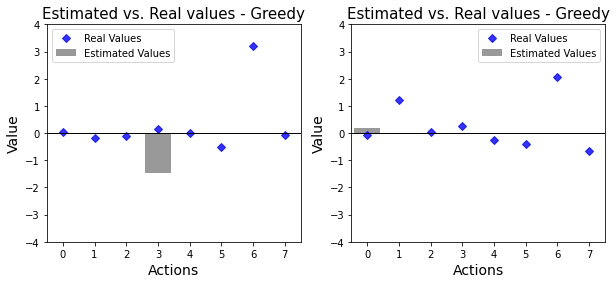

In [ ]:
from locale import NOEXPR
# Initialize the environment of our multi-armed bandit problem
num_experiments = 2
num_bandits = 8
num_steps = 100
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBandits(means, stdev)

# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments,num_bandits)))

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():

    for i in range(num_experiments):
        init_ax(i)   
    
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated vs. Real values - Greedy', fontsize=15)
    temp=[]
    # print(env.mean[i])
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='b', label='Real Values')
    # ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.4, color='blue', label='Estimated Values')
    ax.axhline(0, color='black', lw=1)
    
# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='black', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), interval=10, repeat=False)
plt.show()

100%|██████████| 1000/1000 [00:04<00:00, 229.40it/s]


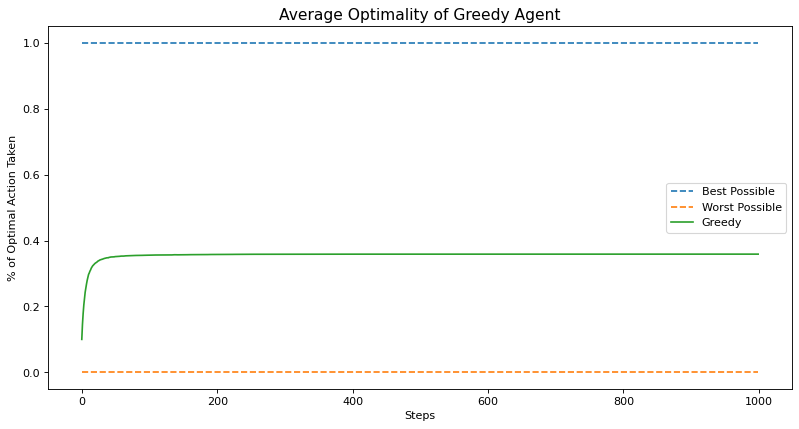

In [ ]:
num_experiments = 10000
num_steps = 1000
num_actions = 10

# Initialize the environment
env = ArmedBanditsGaussian(num_experiments, num_actions)
# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments, num_actions)))

# Store the scores and averages for later plotting
averages = np.zeros((num_steps))
optimality = np.zeros((num_steps))
scores = np.zeros((num_experiments, num_steps+1))

#Store the optimal actions for later use
optimal = np.argmax(env.mean, axis=1)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
  action = agent.get_action()
  _, reward, _, _ = env.step(action)
    
    # Update the agent estimates with the previously observed rewards
  agent.update_estimates(reward, action)
    
    # Store the average cumulative score and optimality of the current step
  scores[:,i+1] = scores[:,i] + reward
  avg_score = np.mean(scores[:,i+1]/(i+1))
  averages[i] = avg_score
    
    # Get optimal actions from the environment
  current_optimality = np.mean(action == optimal)
  optimality[i] = current_optimality
    
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(optimality)
plt.legend(["Best Possible", "Worst Possible", "Greedy"])
plt.title("Average Optimality of Greedy Agent", fontsize=14)
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()
greedy_scores = averages
greedy_optimality = optimality

In [ ]:
class EpsilonGreedyAgent(GreedyAgent):
    def __init__(self, reward_estimates, epsilon):
        GreedyAgent.__init__(self, reward_estimates)
        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        self.epsilon = epsilon
    
    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_experiments) > self.epsilon).astype(int)
        # Generate both types of actions for every experiment
        exploratory_action = np.random.randint(self.num_bandits, size=self.num_experiments)
        greedy_action = argmax(self.reward_estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)
        
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action

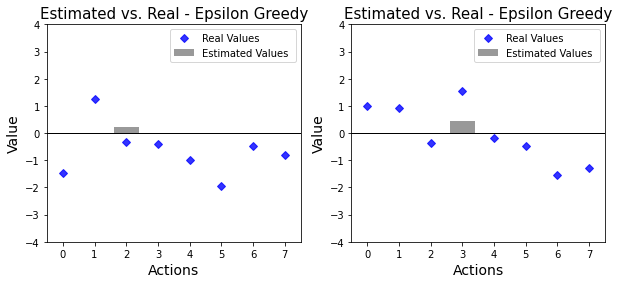

In [ ]:
# Initialize the environment of our multi-armed bandit problem
num_experiments = 2
num_bandits = 8
num_steps = 200
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBandits(means, stdev)

# Initialize the agent
agent = EpsilonGreedyAgent(np.zeros((num_experiments,num_bandits)), 0.1)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    ax1=[]
    for i in range(num_experiments):
        init_ax(i)
    # return ax1
    
        
    
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated vs. Real - Epsilon Greedy', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='b', label='Real Values')
    ax.axhline(0, color='black', lw=1)
    return ax
    
# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        # ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.4, color='blue', label='Estimated Values')
        values = ax.bar(x_pos, estimates, align='center', color='black', alpha=0.4, label='Estimated Values ')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), interval=10, repeat=False)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
# anim.save('./epsilon-greedy-agent.gif', writer='imagemagick', fps=60)


In [ ]:
def run_experiment(num_experiments=1000, num_steps=1000, num_actions=10,epsilon=0.1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = EpsilonGreedyAgent(np.zeros((num_experiments, num_actions)), epsilon)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 100/100 [00:00<00:00, 3649.32it/s]


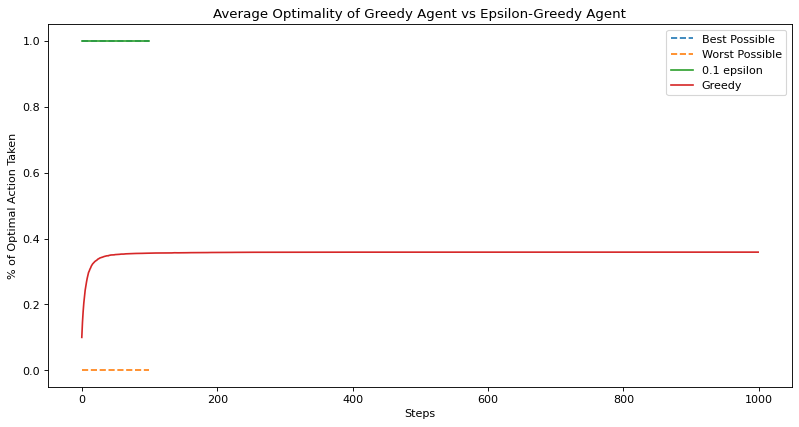

In [ ]:
num_experiments = 500
num_steps = 100
num_actions = 1
epsilon = 0.1

balanced_eps_optimality, balanced_eps_scores = run_experiment(num_experiments, num_steps, num_actions, epsilon)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(balanced_eps_optimality)
plt.plot(greedy_optimality)
plt.legend(["Best Possible", "Worst Possible", "0.1 epsilon", "Greedy"])
plt.title("Average Optimality of Greedy Agent vs Epsilon-Greedy Agent")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1590.23it/s]


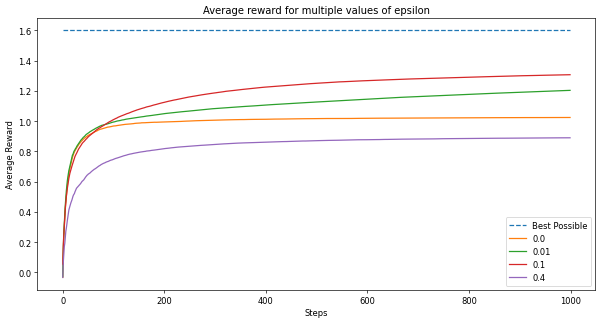

In [ ]:


num_experiments = 1000
num_steps = 1000
num_actions = 10
epsilons = np.array([0.0, 0.01, 0.1, 0.4])

plt.figure(figsize=(12,6), dpi=60, facecolor='w', edgecolor='y')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--')


for epsilon in epsilons:
    _, reward = run_experiment(num_experiments, num_steps, num_actions, epsilon)
    
    plt.plot(reward)
    
plt.legend(["Best Possible"] + epsilons.tolist())
plt.title("Average reward for multiple values of epsilon")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

